# Simple pendulum

In [1]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator

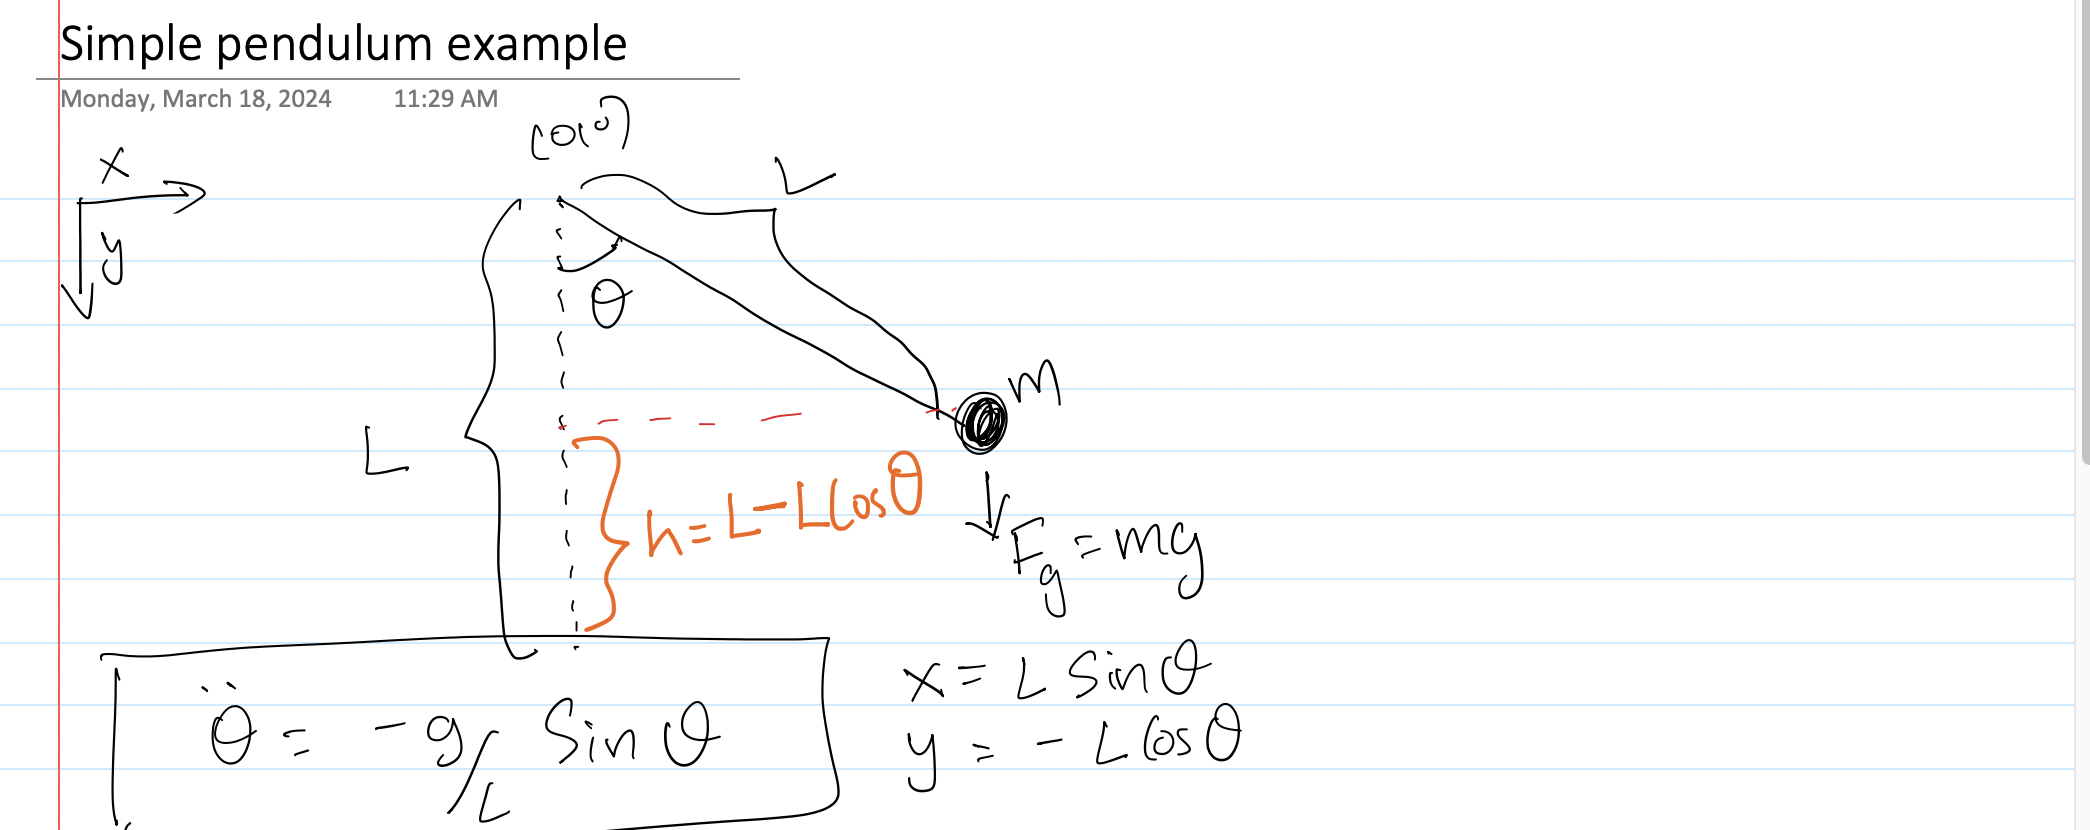

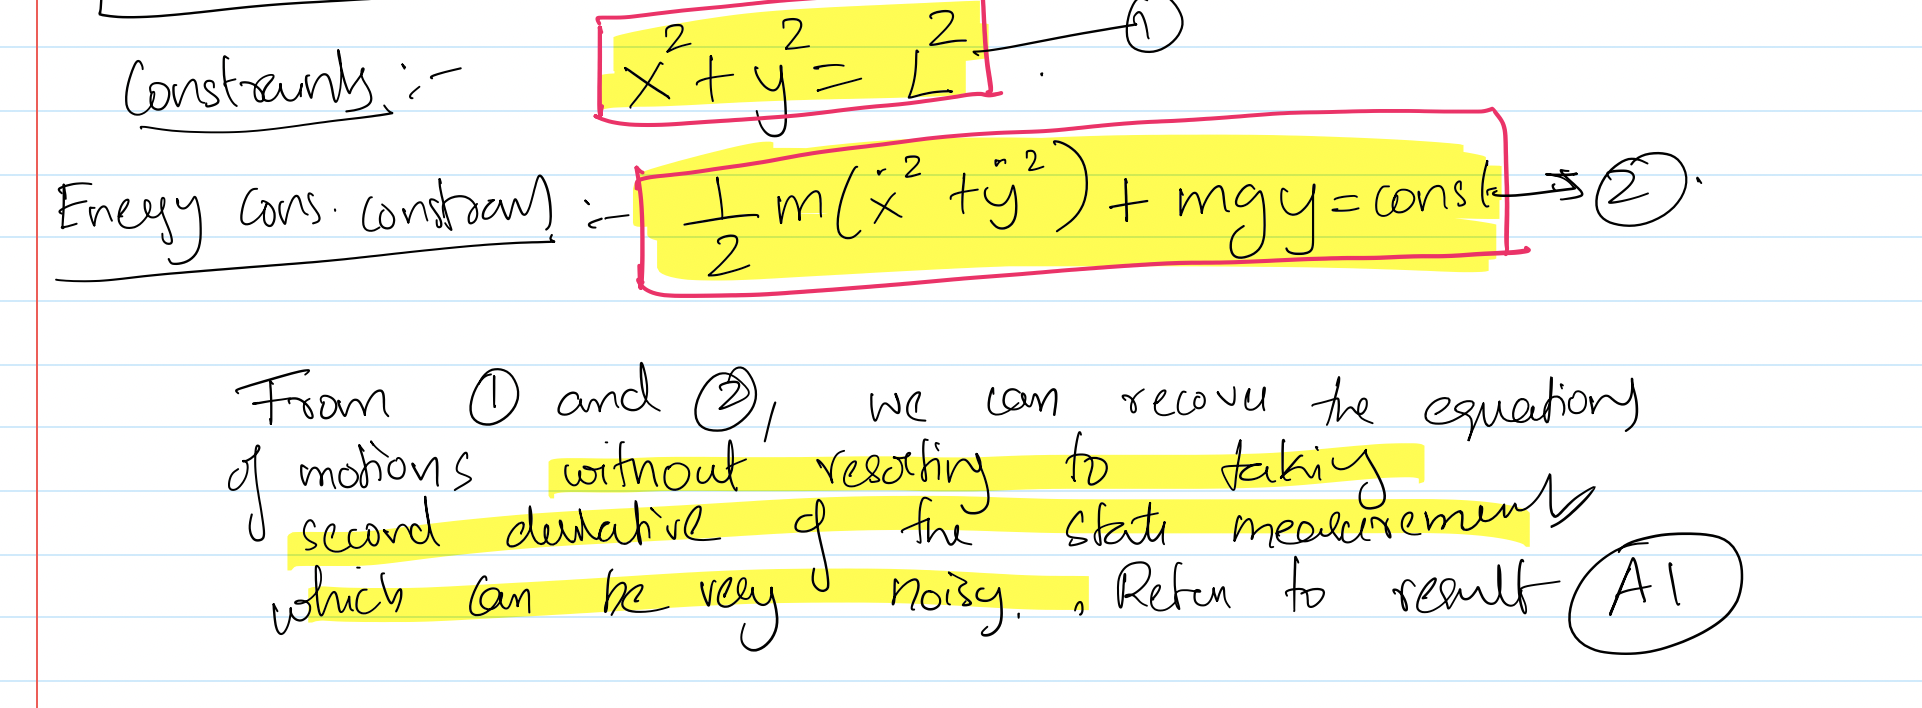

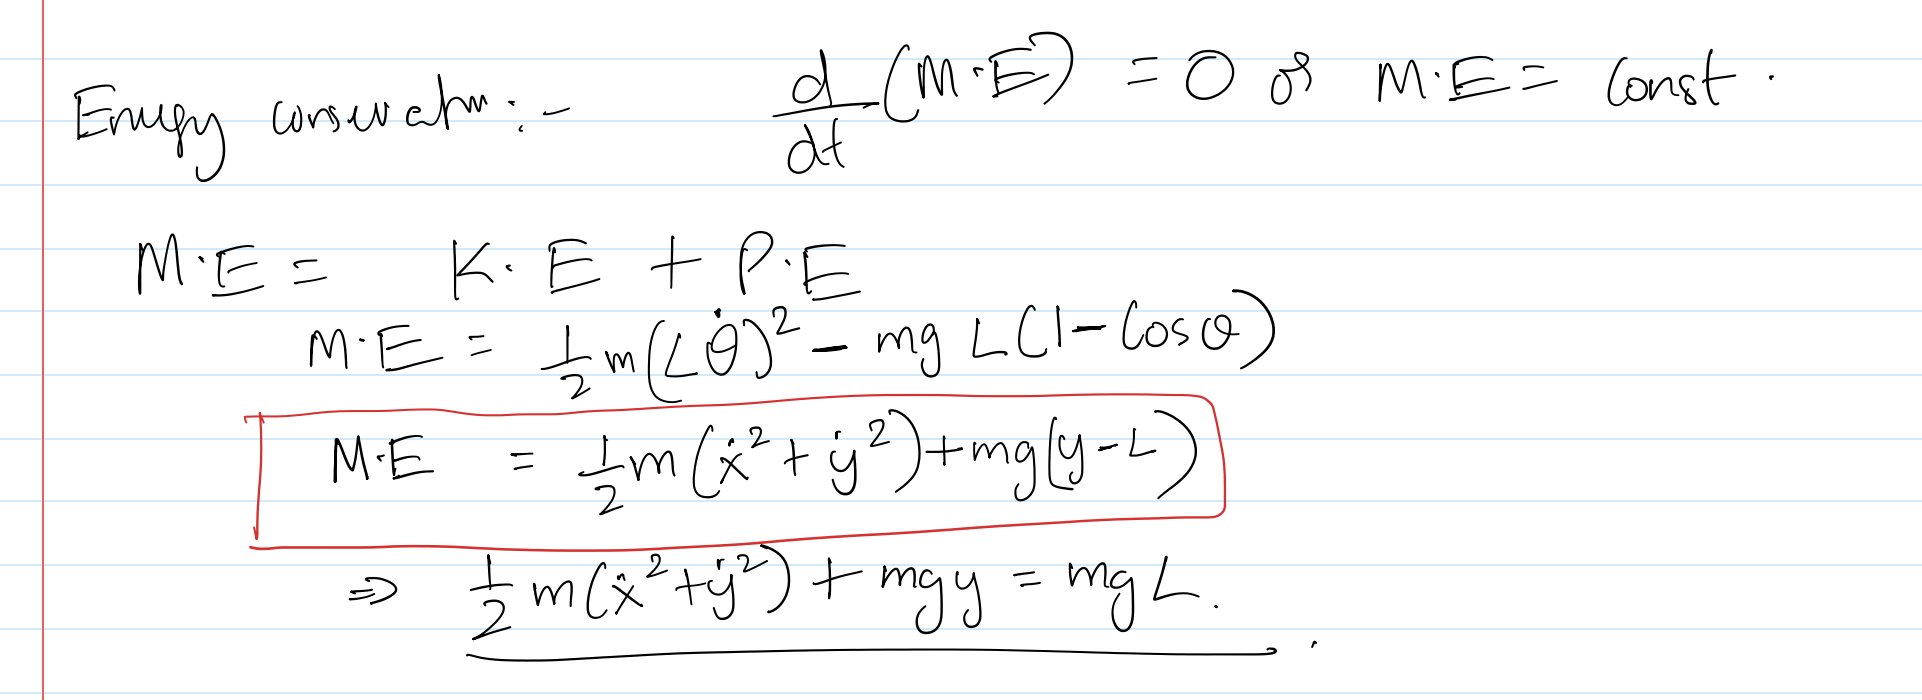

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Function to compute derivatives
def pendulum_rhs(t, y, gamma, L=1):
    """
    Function to compute derivatives for simple pendulum with damping
    
    Parameters:
        t : float
            Time
        y : array_like
            Vector containing [theta, omega], where
            theta is the angle and omega is the angular velocity
        gamma : float
            Damping coefficient
        L : float
            Length of the pendulum
        
    Returns:
        dydt : array_like
            Vector containing [omega, alpha], where
            omega is the angular velocity and alpha is the angular acceleration
    """
    theta, omega = y
    alpha = - (9.81 / L) * np.sin(theta) - gamma * omega
    return [omega, alpha]

# Parameters
theta0 = np.pi / 4  # Initial angle (radians)
omega0 = 0.0        # Initial angular velocity (radians per second)
gamma = 0.0       # Damping coefficient
L = 1.0             # Length of the pendulum (meters)
t_span = (0, 10)    # Time span for the simulation

# Function to integrate the system of ODEs
def integrate_pendulum(t_span, y0, gamma, L):

    sol = solve_ivp(lambda t, y: pendulum_rhs(t, y, gamma, L), t_span, y0, method='RK45', t_eval=np.linspace(*t_span, 1000))
    return sol

# Integrate the pendulum system
sol = integrate_pendulum(t_span, [theta0, omega0], gamma, L)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(sol.t, sol.y[0], label='Angle (radians)')
plt.plot(sol.t, sol.y[1], label='Angular velocity (rad/s)')
plt.title('Damped Simple Pendulum Simulation using scipy.solve_ivp')
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
IC_df = pd.read_csv("parameters/init_cond_simp_pend.csv")

In [4]:
IC_df = IC_df[0:2]
IC_df

In [5]:
# Mechanical eEnergy level
0.5*(IC_df["omega"])**2 + 9.81*(1-np.cos(IC_df["theta"]))

In [6]:
params_df = pd.read_csv("parameters/pend_param.csv")
params_df


In [7]:
g = 9.81   # Acceleration due to gravity (m/s^2)


### Synthesizing data from different ICs

### Synthesizing data from different ICs

In [8]:
L = 5.0
# y_shift = 0.9 * L
# y_shift = 0

num_time_points = 20
# Time span
t_span = (0.0, 10)  # from 0 to 10 seconds
#Valuation points
t_eval_ = np.linspace(t_span[0], t_span[1], num_time_points)
data_matrix_df_list = []


for param_index in params_df.index:
    params = params_df.loc[param_index]
    # Define parameters
    m_c = params['m_c']  # Mass of the cart (kg)
    m_p = params['m_p']  # Mass of the pendulum (kg)
    l = params['l']    # Length of the pendulum (m)
    for IC_index in IC_df.index:
        IC = IC_df.loc[IC_index]
        y0 = IC.values
                # Parameters
        theta0 = IC["theta"]  # Initial angle (radians)
        omega0 = IC["omega"]        # Initial angular velocity (radians per second)
        gamma = 0.0         # Damping coefficient
        # Solve the ODEs
        sol = solve_ivp(lambda t, y: pendulum_rhs(t, y, gamma, L), t_span, [theta0, omega0], method='RK45', t_eval=t_eval_)
        sol_df = pd.DataFrame(sol.y.T, columns=["theta", "omega"])
        sol_df["x"] = L*np.sin(sol_df["theta"])
        sol_df["y"] = -L*np.cos(sol_df["theta"])
        sol_df["t"] = t_eval_
        data_matrix_df_list.append(sol_df[["t", "x", "y"]])
        # if IC_index == 0:
        #     # Plot the results
        #     plt.figure(figsize=(10, 6))
        #     plt.plot(sol.t, sol.y[0], label='Cart Position (x)')
        #     plt.plot(sol.t, sol.y[2], label='Pendulum Angle (theta)')
        #     plt.xlabel('Time (s)')
        #     plt.ylabel('Position (m) / Angle (rad)')
        #     plt.title('Upright Pendulum on Moving Cart')
        #     plt.legend()
        #     plt.grid(True)
        #     plt.show()

data_matrix_df = pd.concat(data_matrix_df_list, ignore_index=True)
data_matrix_df

In [9]:
from dae_finder import add_noise_to_df
noise_perc = 10


data_matrix_features = data_matrix_df_list[0].columns
for ind, data_matrix_ in enumerate(data_matrix_df_list):
    t_exact = data_matrix_["t"]
    noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=111)
    noisy_data_df["t"] = t_exact
    data_matrix_df_list[ind] = noisy_data_df

In [10]:
from scipy import interpolate

In [11]:
#smoothing parameter: when equal weightage: num_data_points * std of data
s_param = num_time_points * (0.01*noise_perc*data_matrix_df_list[1].std()["x"])**2

tck = interpolate.splrep(data_matrix_df_list[1]["t"], data_matrix_df_list[1]["x"], s=s_param)
t_eval_new = np.linspace(t_span[0], t_span[1], 500)
x_new = interpolate.splev(t_eval_new, tck, der=0)

plt.figure()
plt.plot(data_matrix_df_list[1]["t"], data_matrix_df_list[1]["x"], "x", t_eval_new, x_new,
        data_matrix_df[50:100]["t"], data_matrix_df[50:100]["x"], "o")
plt.legend(['Linear', 'Cubic Spline', 'True'])
# plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.title('Cubic-spline interpolation')
plt.show()

In [12]:
(3/4)*np.pi

In [13]:
data_matrix_df[["x","y"]].plot()

### Smoothing data and finding derivatives

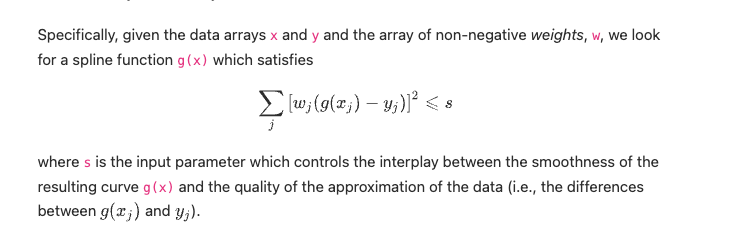

from dae_finder import der_matrix_calculator

from scipy import interpolate

def der_label(feature, der=1):
    if der==0:
        return feature
    elif der==1:
        return "d({}) /dt".format(feature)
    else:
        return "d^{}({}) /dt^{}".format(der, feature, der)

def smooth_data(data_matrix, domain_var = "t", s_param=None, noise_perc=0, derr_order = 1, eval_points = []):
    assert domain_var in data_matrix, "domain variable not found in the data matrix"

    data_t = data_matrix[domain_var]
    num_time_points = len(data_matrix)
    find_s_param = !s_param and s_param !=0

    if len(eval_points)==0:
        eval_points = np.linspace(data_t.iloc[0], data_t.iloc[-1], 10*num_time_points)
    t_eval_new = eval_points
               
    data_matrix_ = data_matrix.drop(domain_var, axis=1)
    data_matrix_std = data_matrix_.std()

    data_matrix_smooth = pd.DataFrame(t_eval_new, columns=[domain_var])
    for feature in data_matrix_:
        if find_s_param:
            #smoothing parameter: when equal weightage: num_data_points * std of data
            s_param = num_time_points * (0.01*noise_perc*data_matrix_std[feature])**2
        tck = interpolate.splrep(data_t, data_matrix_[feature], s=s_param)
        for der_ind in range(derr_order+1):
            smoothed_data = interpolate.splev(t_eval_new, tck, der=der_ind)
            data_matrix_smooth[der_label(feature, der_ind)] = smoothed_data

    return data_matrix_smooth
    



t_eval_new = np.linspace(data_matrix_df_list[1]["t"].iloc[0], data_matrix_df_list[1]["t"].iloc[-1], num_smoothed_points)

smooth_data(data_matrix_df_list[1],derr_order=1, eval_points=t_eval_new, noise_perc=noise_perc) - data_matrix_smooth_df_list[1]

delta_t = t_eval_[1]- t_eval_[0]
data_matrix_features = data_matrix_df_list[0].columns
num_smoothed_points = num_time_points*10
data_matrix_smooth_df_list = []

for ind, data_matrix in enumerate(data_matrix_df_list):
    data_t = data_matrix["t"]
    num_time_points = len(data_matrix)
    data_matrix_ = data_matrix.drop(["t"], axis=1)
    data_matrix_std = data_matrix_.std()
    # print(data_matrix_std)
    t_eval_new = np.linspace(data_t.iloc[0], data_t.iloc[-1], num_smoothed_points)
    data_matrix_smooth = pd.DataFrame(t_eval_new, columns=["t"])
    for feature in data_matrix_:
        #smoothing parameter: when equal weightage: num_data_points * std of data
        s_param = num_time_points * (0.01*noise_perc*data_matrix_std[feature])**2
        # print(s_param)
        # s_param = 0
        
        tck = interpolate.splrep(data_t, data_matrix_[feature], s=s_param)
        smoothed_data = interpolate.splev(t_eval_new, tck, der=0)
        smoothed_derr = interpolate.splev(t_eval_new, tck, der=1)
        data_matrix_smooth[feature] = smoothed_data
        data_matrix_smooth["d({}) /dt".format(feature)] = smoothed_derr

    data_matrix_smooth_df_list.append(data_matrix_smooth)

    
    # derr_matrix = der_matrix_calculator(data_matrix_, delta_t)
    # data_matrix_df_list[ind] = pd.concat([data_matrix_.iloc[:-1], derr_matrix], axis=1)

data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list[:-1], ignore_index=True)

In [14]:
from dae_finder import smooth_data

num_smoothed_points = num_time_points*10

t_eval_new = np.linspace(data_matrix_df_list[0]["t"].iloc[0], data_matrix_df_list[0]["t"].iloc[-1], num_smoothed_points)

#Calling the smoothening function
data_matrix_smooth_df_list = [smooth_data(data_matrix,derr_order=1, noise_perc=noise_perc, eval_points=t_eval_new) for data_matrix in data_matrix_df_list]

data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list[:-1], ignore_index=True)

In [15]:
ind = 1
feature_ = "y"

plt.figure()
# plt.plot(data_matrix_df_list[1]["t"], data_matrix_df_list[1]["x"], "x", t_eval_new, x_new,
#         data_matrix_df[50:100]["t"], data_matrix_df[50:100]["x"], "o")

plt.plot(data_matrix_df_list[ind]["t"], data_matrix_df_list[ind][feature_], "x", data_matrix_smooth_df_list[ind]["t"],
         data_matrix_smooth_df_list[ind][feature_],data_matrix_df[ind*num_time_points:(ind+1)*num_time_points]["t"], data_matrix_df[ind*num_time_points:(ind+1)*num_time_points][feature_], "o")
plt.legend(['Noisy', 'Cubic Spline', 'True'])
# plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.title('Cubic-spline interpolation of {} - Noise: {}%'.format(feature_, noise_perc))
plt.show()

In [16]:
data_matrix_smooth_df_list[0][["d(x) /dt"]].plot()

In [1714]:
data_matrix_smooth_df_list[0][["d(x) /dt"]].plot()

#Taking second derivatives
delta_t = t_eval_[1]- t_eval_[0]
data_matrix_features = data_matrix_df_list[0].columns
for ind, data_matrix_ in enumerate(data_matrix_df_list):
    derr_matrix = der_matrix_calculator(data_matrix_, delta_t)
    data_matrix_df_list[ind] = pd.concat([data_matrix_.iloc[:-1], derr_matrix], axis=1)

data_matrix_df_appended = pd.concat(data_matrix_df_list, ignore_index=True)
data_matrix_df_appended

In [17]:
# data_matrix_df = data_matrix_df_appended[["x","y"]]
# data_matrix_df = pd.concat([data_matrix_df, data_matrix_df_appended[["d(u) /dt"]]], axis=1)
data_matrix_df_smooth = data_matrix_df_smooth_appended[["x","y", "d(x) /dt", "d(y) /dt"]]
data_matrix_df_smooth

In [18]:
from copy import deepcopy
new_df = deepcopy(data_matrix_df_smooth)

new_df["energy"] = 0.5*((new_df["d(x) /dt"])**2 + (new_df["d(y) /dt"])**2) +  9.81*new_df["y"]

new_df.plot()

## Forming candiate library

from sklearn.preprocessing import FunctionTransformer
from copy import deepcopy

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))


data_matrix_df_with_trig = deepcopy(data_matrix_df)
data_matrix_df_with_trig["sin(theta)"] = sin_transformer(1).fit_transform(data_matrix_df_with_trig)["theta"]
data_matrix_df_with_trig["cos(theta)"] = cos_transformer(1).fit_transform(data_matrix_df_with_trig)["theta"]

In [19]:
from dae_finder import PolyFeatureMatrix

poly_feature_ob = PolyFeatureMatrix(2)

candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)

In [20]:
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
candidate_lib_full

candid_lib_comb = pd.concat([candidate_lib_full, data_matrix_df_with_trig[["cos(theta)", "sin(theta)"]]], axis=1)
candid_lib_comb

### SVD analysis

In [21]:
from sklearn import decomposition
pca_1 = decomposition.PCA()
pca_1.fit(candidate_lib_full)

# pca_2 = decomposition.PCA()
# pca_2.fit(mean_candidate_lib)

# pca_3 = decomposition.PCA()
# pca_3.fit(selected_data_matrix_df)

pca_2 = decomposition.PCA()
pca_2.fit(candidate_lib_full.drop(["x^2", "x d(x) /dt"],axis=1))

pca_3 = decomposition.PCA()
pca_3.fit(candidate_lib_full.drop(["x^2", "x d(x) /dt", "y"],axis=1))


# singular_values = pca_1.singular_values_
# mean_singular_values = pca_2.singular_values_

var_expl_ratio = pca_1.explained_variance_ratio_
theta_dot_sq_rem_expl_ratio = pca_2.explained_variance_ratio_
theta_dot_rem_expl_ratio = pca_3.explained_variance_ratio_
# data_var_expl_ratio_E = pca_4.explained_variance_

# var_expl_ratio_E_rem = pca_5.explained_variance_


In [22]:
from matplotlib import pyplot as plt

plt.scatter(np.arange(len(var_expl_ratio)),np.log(var_expl_ratio))
plt.grid()
# for x, y in zip(np.arange(len(candid_lib_sing_values)),np.log(candid_lib_sing_values)):
#     plt.text(x,y,y)

In [23]:
from matplotlib import pyplot as plt

plt.scatter(np.arange(len(theta_dot_sq_rem_expl_ratio)),np.log(theta_dot_sq_rem_expl_ratio))
plt.grid()
# for x, y in zip(np.arange(len(candid_lib_sing_values)),np.log(candid_lib_sing_values)):
#     plt.text(x,y,y)

In [24]:
from matplotlib import pyplot as plt

plt.scatter(np.arange(len(theta_dot_rem_expl_ratio)),np.log(theta_dot_rem_expl_ratio))
plt.grid()
# for x, y in zip(np.arange(len(candid_lib_sing_values)),np.log(candid_lib_sing_values)):
#     plt.text(x,y,y)

### Finding the remaining algebraic relationships

In [25]:
from dae_finder import AlgModelFinder
from dae_finder import sequentialThLin, AlgModelFinder


seq_th_model = sequentialThLin(fit_intercept=True, coef_threshold= 0.1)


algebraic_model_th.fit(candidate_lib_full, scale_columns= False)

In [26]:
seq_th_model = sequentialThLin(fit_intercept=True, coef_threshold= 0.05)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)

algebraic_model_th.fit(candidate_lib_full.drop(["x^2", "x d(x) /dt"], axis=1), scale_columns= False)

In [27]:
algebraic_model_th.best_models(5)

In [28]:
#Use lasso model by default
algebraic_model_1 = AlgModelFinder(model_id='lasso', alpha=0.3, fit_intercept=True)
algebraic_model_1.fit(candidate_lib_full, scale_columns= True)


algebraic_model_1.best_models(5)

In [29]:
#Use lasso model by default
algebraic_model_1 = AlgModelFinder(model_id='lasso', alpha=0.3, fit_intercept=True)
algebraic_model_1.fit(candidate_lib_full.drop(["x^2", "x d(x) /dt"], axis=1), scale_columns= True)


algebraic_model_1.best_models(5)

In [1701]:
from sklearn.linear_model import LinearRegression

In [1702]:
model_lin = LinearRegression(fit_intercept= True)

model_lin.fit(X=candidate_lib_full[["d(y) /dt^2", "d(x) /dt^2"]], y=candidate_lib_full["y"])

In [1648]:
dict(zip(model_lin.feature_names_in_, model_lin.coef_))

In [1555]:
model_lin.intercept_

In [1556]:
# Expected coefficient of x_dot^2 and y_dot^2 
1/(9.8*2) #1/2 * 1/g

In [1557]:
# Expected intercept (coming from energy)
L #L

In [1558]:
model_lin = LinearRegression(fit_intercept= True)

model_lin.fit(X=candidate_lib_full[["y^2", "d(y) /dt^2"]], y=candidate_lib_full["x^2"])

In [1559]:
dict(zip(model_lin.feature_names_in_, model_lin.coef_))

In [1446]:
model_lin.intercept_